# Plot Cosmosis Chains

In [1]:
pwd

'/Users/aa3044/Documents/GitHub/CUDA_Programming/project'

In [3]:
import pandas as pd

def read_cosmosis_chain(filename):
    header = []
    # Read only the header line
    with open(filename, 'r') as f:
        for line in f:
            if not line.startswith('#'):
                break
            else:
                header.append(line)
    raw_names = header[0].strip('#').strip().split('\t')
    clean_names = [name.split('--')[-1] for name in raw_names]

    # Load the actual data
    df = pd.read_csv(filename, comment='#', delim_whitespace=True, header=None)
    df.columns = clean_names
    return df

# Usage
chain_file = '/Users/aa3044/Documents/GitHub/CUDA_Programming/project/outputs/test_per_bin.txt'
#chain_file = '/global/u2/a/arwa_mq/DESy3/Boost_Factor/outputs/test_per_bin.txt'
#chain_file00 = '/Users/aa3044/Documents/GitHub/DESy3/Boost_Factor/data/test_per_binc00.txt'
#chain_file10 = '/Users/aa3044/Documents/GitHub/DESy3/Boost_Factor/data/test_per_binc10.txt' 
#chain_file20 = '/Users/aa3044/Documents/GitHub/DESy3/Boost_Factor/data/test_per_binc20.txt' 
#chain_file30 = '/Users/aa3044/Documents/GitHub/DESy3/Boost_Factor/data/test_per_binc30.txt'  
#test_per_bin00for_plot.txt'
df00 = read_cosmosis_chain(chain_file)
#df10 = read_cosmosis_chain(chain_file10)
#df20 = read_cosmosis_chain(chain_file20)
#df30 = read_cosmosis_chain(chain_file30)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/aa3044/Documents/GitHub/CUDA_Programming/project/outputs/test_per_bin.txt'

In [3]:
# df = df.drop(columns='prior')
df

,logrs_00,logb0_00,prior,post
0,0.000396,0.001193,-1.386294,-152646.497648
1,0.001888,0.000944,-1.386294,-153369.673829
2,0.001456,-0.000673,-1.386294,-151895.217537
3,-0.006808,0.001075,-1.386294,-148225.124755
4,-0.005840,0.001264,-1.386294,-148938.978143
...,...,...,...,...
249995,-0.576652,-0.674651,-1.386294,-12.959660
249996,-0.454151,-0.761367,-1.386294,-5.230158
249997,-0.494431,-0.706894,-1.386294,-6.049266
249998,-0.621875,-0.589040,-1.386294,-8.109921


In [5]:
print(df.columns.tolist()) 

['logrs_00', 'logb0_00', 'prior', 'post']


In [2]:
from getdist import plots, MCSamples
import matplotlib.pyplot as plt
import numpy as np

def plot_corner_getdist(df, param_labels=None, name_tag='chain', sigma_clip=3, external_means=None):
    """
    Generate a corner plot from a CosmoSIS DataFrame using GetDist.
    - Converts 'log' parameters to linear scale.
    - Clips each parameter to +/- N sigma.
    
    Parameters:
    - df: pandas DataFrame with samples, may contain a 'post' column.
    - param_labels: Optional list of LaTeX-style labels.
    - name_tag: Optional string to tag the chain.
    - sigma_clip: Number of standard deviations for clipping (default: 5σ).

    Returns:
    - fig: The matplotlib figure object.
    """
    # Drop 'prior' column if it exists
    df_params = df.drop(columns=['prior','post']) if 'prior' in df.columns else df.copy()

    # Drop rows with NaN or inf
    df_params = df_params.replace([np.inf, -np.inf], np.nan).dropna()

    # Convert log columns to linear and rename
    clean_names = []
    for col in df_params.columns:
        if col.startswith('log'):
            df_params[col] = 10**df_params[col]
            clean_names.append(col[3:])  # remove 'log'
        else:
            clean_names.append(col)
    df_params.columns = clean_names

    # 5-sigma clipping
    for col in df_params.columns:
        mu = df_params[col].mean()
        sigma = df_params[col].std()
        df_params = df_params[(df_params[col] > mu - sigma_clip * sigma) &
                              (df_params[col] < mu + sigma_clip * sigma)]

    # Parameter labels
    labels = param_labels if param_labels is not None else clean_names
    truths = [external_means.get(name, (None,))[0] for name in clean_names]
    print(truths)
    # GetDist MCSamples
    samples = MCSamples(samples=df_params.values,
                        names=clean_names,
                        labels=labels,
                        name_tag=name_tag)

    # Plot
    g = plots.getSubplotPlotter()
    g.triangle_plot([samples], filled=True, truths=truths, truth_color='r')
    # For each parameter, add a vertical reference line at the external mean
    for pname, (mean, sigma) in external_means.items():
        if mean is not None and pname in clean_names:
            # Get the axis for the 1D marginal of this parameter
            ax = g.subplots[clean_names.index(pname), clean_names.index(pname)]
            ax.axvline(mean, color='k', linestyle='--', linewidth=1.5)
            # Optional: add ±1σ shading
            ax.axvspan(mean - sigma, mean + sigma, color='gray', alpha=0.2)
    return g.fig


In [11]:
#new
from getdist import plots, MCSamples
import numpy as np
import matplotlib.pyplot as plt

def plot_multiple_corner_getdist(dfs, param_labels=None, name_tags=None, sigma_clip=3, external_means=None):
    """
    Generate a corner plot from multiple CosmoSIS DataFrames using GetDist.
    - Converts 'log' parameters to linear scale.
    - Clips each parameter to +/- N sigma.
    
    Parameters:
    - dfs: List of pandas DataFrames (one per CosmoSIS chain)
    - param_labels: Optional list of LaTeX-style labels.
    - name_tags: List of strings for each chain (optional)
    - sigma_clip: Number of standard deviations for clipping.
    - external_means: Dict of external mean values and uncertainties {param: (mean, sigma)}

    Returns:
    - fig: The matplotlib figure object.
    """
    samples_list = []
    clean_names = None

    for i, df in enumerate(dfs):
        df_params = df.drop(columns=['prior','post'], errors='ignore')
        df_params = df_params.replace([np.inf, -np.inf], np.nan).dropna()

        # Convert log columns to linear
        current_names = []
        for col in df_params.columns:
            if col.startswith('log'):
                df_params[col] = 10**df_params[col]
                current_names.append(col[3:])
            else:
                current_names.append(col)
        df_params.columns = current_names

        if clean_names is None:
            clean_names = current_names
        else:
            # Check consistency
            assert clean_names == current_names, f"Mismatch in parameter names between chains at index {i}"

        # Sigma clipping
        for col in df_params.columns:
            mu = df_params[col].mean()
            sigma = df_params[col].std()
            df_params = df_params[(df_params[col] > mu - sigma_clip * sigma) &
                                  (df_params[col] < mu + sigma_clip * sigma)]

        # Labels and MCSamples
        labels = param_labels if param_labels is not None else clean_names
        tag = name_tags[i] if name_tags is not None else f'chain_{i+1}'
        samples = MCSamples(samples=df_params.values, names=clean_names, labels=labels, name_tag=tag)
        samples_list.append(samples)

    # Truth lines (one value per parameter)
    truths = [external_means.get(name, (None,))[0] for name in clean_names] if external_means else None

    # Plot
    g = plots.getSubplotPlotter()
    g.triangle_plot(samples_list, filled=True, truths=truths, truth_color='r')

    # Optional: add vertical reference lines at external means
    if external_means:
        for pname, (mean, sigma) in external_means.items():
            if mean is not None and pname in clean_names:
                idx = clean_names.index(pname)
                ax = g.subplots[idx, idx]
                ax.axvline(mean, color='k', linestyle='--', linewidth=1.5)
                ax.axvspan(mean - sigma, mean + sigma, color='gray', alpha=0.2)

    return g.fig


In [14]:
import pandas as pd

# Load your four CosmoSIS output files


external_means = {
    'rs_00': (0.44, 0.06),
    'b0_00': (0.34, 0.05)
}

fig = plot_multiple_corner_getdist(
    [df00, df10, df20, df30],
    name_tags=['Rich bin 1', 'Rich bin 2', 'Rich bin 3', 'Rich bin 4'],
    external_means=external_means
)


Removed no burn in


AssertionError: Mismatch in parameter names between chains at index 1

In [15]:
for i, df in enumerate([df00, df10, df20, df30]):
    cols = [col[3:] if col.startswith('log') else col for col in df.drop(columns=['prior', 'post'], errors='ignore').columns]
    print(f"Chain {i}: {cols}")


Chain 0: ['rs_00', 'b0_00']
Chain 1: ['rs_10', 'b0_10']
Chain 2: ['rs_20', 'b0_20']
Chain 3: ['rs_30', 'b0_30']


In [16]:
from getdist import plots, MCSamples
import numpy as np
import matplotlib.pyplot as plt

def plot_multiple_corner_getdist_boost(dfs, param_labels=None, name_tags=None, sigma_clip=3, external_means=None):
    """
    Plot corner plot comparing boost factor params across richness bins for the same z.
    Renames rs_* -> rs and b0_* -> b0.
    """
    samples_list = []
    for i, df in enumerate(dfs):
        df_params = df.drop(columns=['prior','post'], errors='ignore')
        df_params = df_params.replace([np.inf, -np.inf], np.nan).dropna()

        # Rename log columns and convert to linear
        renamed_cols = {}
        for col in df_params.columns:
            new_col = col
            if col.startswith('log'):
                df_params[col] = 10**df_params[col]
                new_col = col[3:]
            if 'rs' in new_col:
                new_col = 'rs'
            elif 'b0' in new_col:
                new_col = 'b0'
            renamed_cols[col] = new_col
        df_params = df_params.rename(columns=renamed_cols)

        # Sigma clipping
        for col in df_params.columns:
            mu = df_params[col].mean()
            sigma = df_params[col].std()
            df_params = df_params[(df_params[col] > mu - sigma_clip * sigma) &
                                  (df_params[col] < mu + sigma_clip * sigma)]

        labels = param_labels if param_labels is not None else list(df_params.columns)
        tag = name_tags[i] if name_tags is not None else f'chain_{i+1}'

        samples = MCSamples(samples=df_params.values, names=df_params.columns.tolist(), labels=labels, name_tag=tag)
        samples_list.append(samples)

    # Truths
    truths = [external_means.get(name, (None,))[0] for name in samples_list[0].getParamNames().names] if external_means else None

    # Plot
    g = plots.getSubplotPlotter()
    g.triangle_plot(samples_list, filled=True, truths=truths, truth_color='r')

    # Optional: add vertical reference lines
    if external_means:
        for pname, (mean, sigma) in external_means.items():
            if mean is not None:
                idx = samples_list[0].getParamNames().names.index(pname)
                ax = g.subplots[idx, idx]
                ax.axvline(mean, color='k', linestyle='--', linewidth=1.5)
                ax.axvspan(mean - sigma, mean + sigma, color='gray', alpha=0.2)

    return g.fig


Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


ValueError: 'rs' is not in list

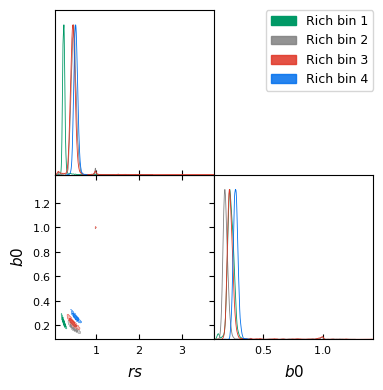

In [18]:
fig = plot_multiple_corner_getdist_boost(
    [df00, df10, df20, df30],
    name_tags=['Rich bin 1', 'Rich bin 2', 'Rich bin 3', 'Rich bin 4'],
    external_means={'rs': (0.44, 0.06), 'b0': (0.34, 0.05)}
)


In [ ]:
from getdist import plots, MCSamples
import numpy as np
import matplotlib.pyplot as plt

def plot_multiple_corner_getdist_boost(dfs, param_labels=None, name_tags=None, sigma_clip=3,
                                       external_means=None, param_ranges=None):
    samples_list = []
    for i, df in enumerate(dfs):
        df_params = df.drop(columns=['prior','post'], errors='ignore')
        df_params = df_params.replace([np.inf, -np.inf], np.nan).dropna()

        # Rename log columns and convert to linear
        renamed_cols = {}
        for col in df_params.columns:
            new_col = col
            if col.startswith('log'):
                df_params[col] = 10**df_params[col]
                new_col = col[3:]
            if 'rs' in new_col:
                new_col = 'rs'
            elif 'b0' in new_col:
                new_col = 'b0'
            renamed_cols[col] = new_col
        df_params = df_params.rename(columns=renamed_cols)

        # Sigma clipping
        for col in df_params.columns:
            mu = df_params[col].mean()
            sigma = df_params[col].std()
            df_params = df_params[(df_params[col] > mu - sigma_clip * sigma) &
                                  (df_params[col] < mu + sigma_clip * sigma)]

        labels = param_labels if param_labels is not None else list(df_params.columns)
        tag = name_tags[i] if name_tags is not None else f'chain_{i+1}'

        samples = MCSamples(samples=df_params.values,
                            names=df_params.columns.tolist(),
                            labels=labels,
                            name_tag=tag,
                            ranges=param_ranges)
        samples_list.append(samples)

    truths = [external_means.get(name, (None,))[0] for name in samples_list[0].getParamNames().names] if external_means else None

    g = plots.getSubplotPlotter()
    g.settings.num_plot_contours = 3
    g.triangle_plot(samples_list, filled=True, truths=truths, truth_color='r')

    # Optional: external mean lines
    if external_means:
        for pname, (mean, sigma) in external_means.items():
            if mean is not None and pname in samples_list[0].getParamNames().names:
                idx = samples_list[0].getParamNames().names.index(pname)
                ax = g.subplots[idx, idx]
                ax.axvline(mean, color='k', linestyle='--', linewidth=1.5)
                ax.axvspan(mean - sigma, mean + sigma, color='gray', alpha=0.2)

    return g.fig


Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


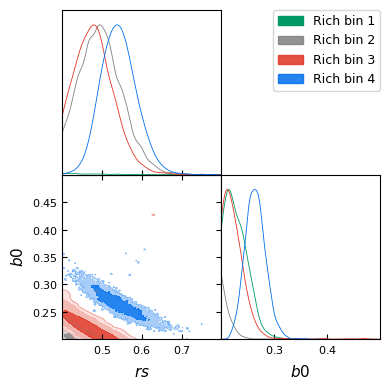

In [28]:
param_ranges = {'rs': (0.4, 0.8), 'b0': (0.2, 0.5)}

fig = plot_multiple_corner_getdist_boost(
    [df00, df10, df20, df30],
    name_tags=['Rich bin 1', 'Rich bin 2', 'Rich bin 3', 'Rich bin 4'],
    external_means=None,
    param_ranges=param_ranges
)


Removed no burn in
Removed no burn in


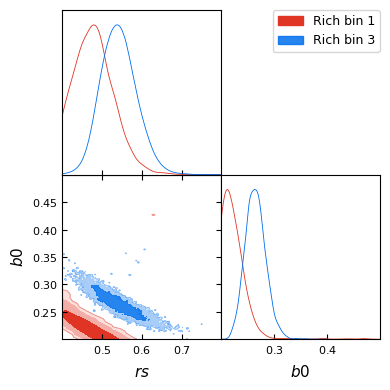

In [31]:
param_ranges = {'rs': (0.4, 0.8), 'b0': (0.2, 0.5)}

fig = plot_multiple_corner_getdist_boost(
    [df20, df30],
    name_tags=['Rich bin 1', 'Rich bin 3'],
    external_means=None,
    param_ranges=param_ranges
)


In [3]:
external_means = {
    'b0_00': (0.34, 0.05),
    'rs_00': (0.44, 0.06)
}

[0.44, 0.34]
Removed no burn in


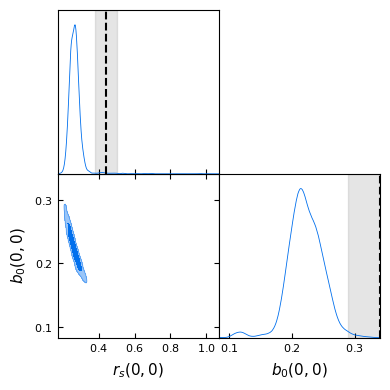

In [32]:
labels = [r"r_s (0,0) ", r"b_0 (0,0)"]
fig = plot_corner_getdist(df00, param_labels=labels, external_means=external_means)
plt.show()

In [ ]:
#

In [ ]:
#

In [ ]:
#

In [ ]:
#

In [ ]:
#

In [ ]:
#

In [ ]:
#

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def plot_trace(df, burnin=0.0, external_means=None):
    """
    Plot trace plots with:
    - Horizontal lines at sample mean (red dashed)
    - Optional reference values from other work (black dashed)

    Parameters:
    - df: pandas DataFrame with samples, may include 'post'.
    - burnin: fraction of samples to discard.
    - external_means: dict of {param_name: (mean, sigma)} in linear scale.

    Returns:
    - fig: matplotlib figure.
    """
    # Drop 'post' column and clean
    df_params = df.drop(columns='prior') if 'prior' in df.columns else df.copy()
    df_params = df_params.replace([np.inf, -np.inf], np.nan).dropna()

    # Convert log columns to linear
    trace_df = df_params.copy()
    new_names = []
    for col in trace_df.columns:
        if col.startswith("log"):
            trace_df[col] = 10**trace_df[col]
            new_names.append(col[3:])
        else:
            new_names.append(col)
    trace_df.columns = new_names

    # Apply burn-in
    if burnin > 0.0:
        n = int(len(trace_df) * burnin)
        trace_df = trace_df.iloc[n:]

    # Plot setup
    n_params = len(trace_df.columns)
    fig, axes = plt.subplots(n_params, 1, figsize=(10, 2.5 * n_params), sharex=True)
    if n_params == 1:
        axes = [axes]

    for i, col in enumerate(trace_df.columns):
        data = trace_df[col].values
        sample_mean = data.mean()

        axes[i].plot(data, lw=0.7, alpha=0.8)
        axes[i].axhline(sample_mean, color='r', linestyle='--', label=f'sample mean = {sample_mean:.3g}')

        if external_means and col in external_means:
            ref_mean, ref_sigma = external_means[col]
            axes[i].axhline(ref_mean, color='k', linestyle='--', label=f'ref = {ref_mean:.2f}')
            axes[i].fill_between(
                np.arange(len(data)),
                ref_mean - ref_sigma,
                ref_mean + ref_sigma,
                color='gray',
                alpha=0.2,
                label='±1σ ref'
            )

        axes[i].set_ylabel(col)
        axes[i].legend()
        axes[i].grid(True)

    axes[-1].set_xlabel("Sample index")
    fig.suptitle("Trace Plots with Sample Mean and External Reference", fontsize=15)
    fig.tight_layout(rect=[0, 0, 1, 0.96])

    return fig


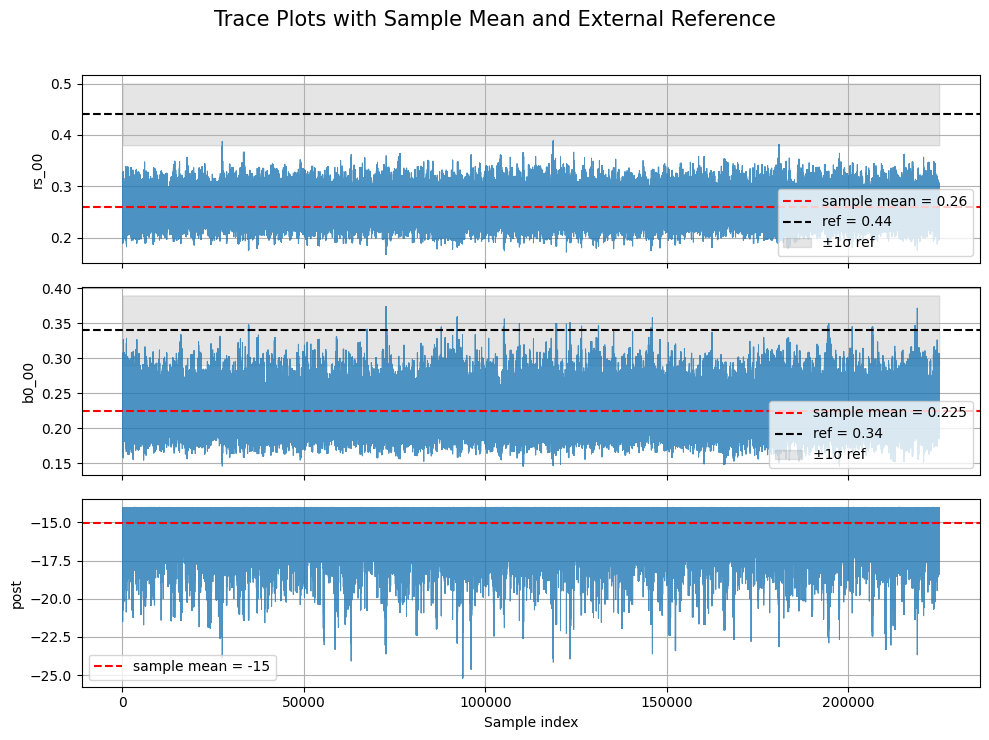

In [18]:
external_means = {
    'b0_00': (0.34, 0.05),
    'rs_00': (0.44, 0.06)
}

fig = plot_trace(df, burnin=0.1, external_means=external_means)
plt.show()